In [6]:
import ms_import as ms
from UniDec import unidec
from UniDec.unidec_modules import unidectools as ud
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from ctypes import *
import sys
import os
import baf2sql
from pathlib import Path
import time 

In [16]:
def find_nearest(array, value):
    """Returns index of float/int closest to value you want to find"""
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()


def upload_bruker(analysis_dir, first_peak = None, spacing = None, time_window = 10, num_peaks = None,
                  plot_LC = False, raw_calibration = False):
    
    """Returns numpy arrays of the mean m/z and intensity within a time window containing highest base-peak intensity"""
    
    tstart = time.perf_counter()
    
    
    # check time window
    if time_window % 2 != 0: 
        raise ValueError("time_window must be even")

    # --- data extraction using baf2sql DLL 

    # if sys.version_info.major == 2:
    #     # note: assuming a european Windows here...
    #     analysis_dir = unicode(analysis_dir, 'cp1252') #???
        
    baf_fn = os.path.join(analysis_dir, "analysis.baf")
    sqlite_fn = baf2sql.getSQLiteCacheFilename(baf_fn)
    conn = sqlite3.connect(sqlite_fn)

    # --- Count spectra
    q = conn.execute("SELECT COUNT(*) FROM Spectra "
                    "WHERE LineMzId NOT NULL AND ProfileMzId NOT NULL")
    row = q.fetchone()
    N = row[0]
    print("Specified BAF has {} spectra with line and profile data.".format(N))

    # --- Plot TIC and BPC over MS^1 spectra
    q = conn.execute("SELECT Rt, SumIntensity, MaxIntensity FROM Spectra s "
                    "JOIN AcquisitionKeys ak ON s.AcquisitionKey = ak.Id "
                    "WHERE ak.MsLevel = 0 "
                    "ORDER BY s.ROWID")
    data = [ row for row in q ]
    rt = [ row[0] for row in data ]
    tic = [ row[1] for row in data ]
    bpc = [ row[2] for row in data ]

    # plot LC
    if plot_LC == True:

        plt.figure()
        plt.plot(rt, tic)
        plt.plot(rt, bpc, '--')
        plt.xlabel('retention time / s')
        plt.ylabel('intensity / a.u.')
        plt.legend(['TIC', 'BPC'])
        plt.show()


    # --- Get mean spectrum for the largest peak within a time window 
    if spacing == None:
        np_bpc = np.array(bpc, dtype = 'float')

        # get time window around base-peak intensity 
        rt_range = rt[np.nanargmax(np_bpc) - int(time_window/2): np.nanargmax(np_bpc) + int(time_window/2 + 1)]

        spec_vals = {'profile_mz':[], 'profile_int':[]}

        for i in rt_range: 

            q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                            "WHERE ABS(Rt - {}) < 1e-8".format(i))
                        
            row = q.fetchone()

            bs = baf2sql.BinaryStorage(baf_fn, raw_calibration = raw_calibration)

            if not all(row) == False: # check for None values

                bs = baf2sql.BinaryStorage(baf_fn, raw_calibration = raw_calibration)

                profile_mz = bs.readArrayDouble(row[2])
                profile_int = bs.readArrayDouble(row[3])

                spec_vals['profile_mz'].append(profile_mz)
                spec_vals['profile_int'].append(profile_int)
    
        mean_profile_mz = np.average(np.array(spec_vals['profile_mz']), axis = 0)
        mean_profile_int = np.average(np.array(spec_vals['profile_int']), axis = 0)
            
            
        folder = "Preprocessed_" + analysis_dir[:-2]
        Path(folder).mkdir(parents=True, exist_ok = True)

        np.savetxt(folder+"/"+folder+".txt" , np.array([mean_profile_mz, mean_profile_int]).T, delimiter = "\t")
        np.savetxt(folder+"/"+folder+"_LC.txt" , np.array([rt, bpc]), delimiter = "\t")
            
    # extract data for multiple peaks         
    if spacing != None and num_peaks != None: 
        
        np_bpc = np.array(bpc, dtype = 'float')
        
        # get time stamps for each peak
        peak_times = [first_peak + i*spacing for i in range(num_peaks)]
        
        
        # loops through peaks, calculates mean spectrum within time window for each and stores in .txt file
        for i in range(num_peaks):
            
            # get nearest time point
            nearest = find_nearest(rt, peak_times[i])
            
            # get range for which to mean over
            rt_range = rt[(nearest - int(time_window/2)):(nearest + int(time_window/2 + 1))]
            
            spec_vals = {'profile_mz':[], 'profile_int':[]}
            
            for j in rt_range: 

                q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                                "WHERE ABS(Rt - {}) < 1e-8".format(j))

                row = q.fetchone()

                bs = baf2sql.BinaryStorage(baf_fn, raw_calibration = raw_calibration)

                if not all(row) == False: # check for None values

                    bs = baf2sql.BinaryStorage(baf_fn, raw_calibration = raw_calibration)

                    profile_mz = bs.readArrayDouble(row[2])
                    profile_int = bs.readArrayDouble(row[3])

                    spec_vals['profile_mz'].append(profile_mz)
                    spec_vals['profile_int'].append(profile_int)
                else:
                    print("No spectra found at {} seconds".format(peak_times[i]))
                    
            mean_profile_mz = np.average(np.array(spec_vals['profile_mz']), axis = 0)
            mean_profile_int = np.average(np.array(spec_vals['profile_int']), axis = 0)
            
            folder = "preprocessed_files_" + analysis_dir[:-2] 
            
            Path(folder).mkdir(parents=True, exist_ok = True)
            np.savetxt(folder+"/"+folder+ "peak_at_{}s.txt".format(peak_times[i]), 
                       np.array([mean_profile_mz, mean_profile_int]).T, delimiter = "\t")
            
        print("Peaks saved to {}".format(folder))
        
        return peak_times # this will be updated as an attribute within a class 
    
    tend = time.perf_counter()
    
    print("Loading Time: {.:f}".format(tend - tstart))
     

Specified BAF has 1070 spectra with line and profile data.


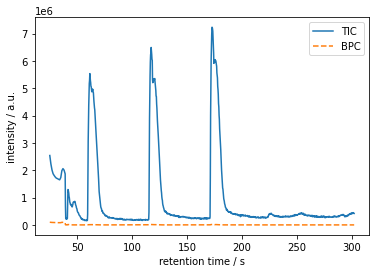

Peaks saved to preprocessed_files_3x_injection


In [17]:
analysis_dir = "3x_injection.d"

bruker_data = upload_bruker(analysis_dir, first_peak = 114, spacing = 56, time_window = 2, num_peaks = 3,
                  plot_LC = True, raw_calibration = False)

In [12]:
max(bruker_data)


302.235


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\MS-Analysis\UniDec\unidec_bin\UniDec.exe
Opening File:  C:\Users\cm19ljc\Documents\GitHub\MS-Analysis/preprocessed_files_3x_injection\preprocessed_files_3x_injectionpeak_at_114s.txt
Loading Time: 9.3s


C:\Users\cm19ljc\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Automatic Peak Width: 0.09537
Linear False
Data Prep Time: 5s
UniDec run 0.29s
File Name:  C:\Users\cm19ljc\Documents\GitHub\MS-Analysis/preprocessed_files_3x_injection\preprocessed_files_3x_injectionpeak_at_114s.txt R Squared:  -5.0553197529398135
Exported data to C:\Users\cm19ljc\Documents\GitHub\MS-Analysis/preprocessed_files_3x_injection\preprocessed_files_3x_injectionpeak_at_114s_unidecfiles\preprocessed_files_3x_injectionpeak_at_114s_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11021.60  1.91  20.00 ...  11021.60  0.20  0.00]
 [ 11043.60  0.65  6.81 ...  11043.60  0.20  0.04]
 [ 11063.50  1.79  18.73 ...  11063.50  0.20  0.04]
 ...
 [ 14927.90  1.81  19.00 ...  14927.90  0.20  0.00]
 [ 14943.10  0.70  7.34 ...  14943.10  0.20  0.11]
 [ 14978.20  1.05  11.00 ...  14978.20  0.20  0.00]]
Peak Parameters (Saved To C:\Users\cm19ljc\Documents\GitHub\MS-Analysis/preprocessed_files_3x_injection\preprocessed_files_3x_inject

C:\Users\cm19ljc\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Automatic Peak Width: 0.10271
Linear False
Data Prep Time: 5.1s
UniDec run 0.34s
File Name:  C:\Users\cm19ljc\Documents\GitHub\MS-Analysis/preprocessed_files_3x_injection\preprocessed_files_3x_injectionpeak_at_226s.txt R Squared:  -0.9732542220635905
Exported data to C:\Users\cm19ljc\Documents\GitHub\MS-Analysis/preprocessed_files_3x_injection\preprocessed_files_3x_injectionpeak_at_226s_unidecfiles\preprocessed_files_3x_injectionpeak_at_226s_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11024.60  1.95  19.00 ...  11024.60  0.20  0.00]
 [ 11109.00  0.97  9.46 ...  11109.00  0.20  0.00]
 [ 11133.20  0.89  8.68 ...  11133.12  0.40  0.05]
 ...
 [ 14965.30  1.03  10.00 ...  14965.30  0.20  0.00]
 [ 14979.90  1.22  11.90 ...  14979.94  0.30  0.20]
 [ 14992.80  1.23  12.00 ...  14992.84  0.30  0.27]]
Peak Parameters (Saved To C:\Users\cm19ljc\Documents\GitHub\MS-Analysis/preprocessed_files_3x_injection\preprocessed_files_3x_inje

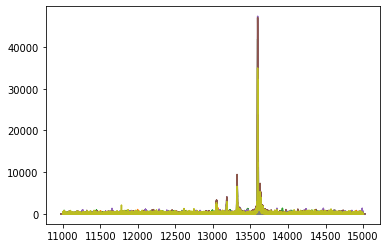

In [18]:
# iterate through files made by the above function
data_dir = os.getcwd() + "/preprocessed_files_3x_injection/"

unidec_data = {}

for filename in os.listdir(data_dir):
    if filename[-3:] == 'txt':
        # get peak time 
        for i in bruker_data: 
            x = filename.find(str(i))
            if x != -1:
                pk = i
        # set up dictionary to hold unidec data
        unidec_data[pk] = {}

        # set up unidec 
        eng = unidec.UniDec()
        eng.open_file(data_dir+filename)

        # -- Data processing 
        eng.config.subtype = 2 # background subtraction - subtract curved
        eng.config.subbuff = 100 # background subtraction amount(subtract curved) 0 = 0ff, 100 = good amount when on
        eng.config.datanorm = 0 # turn off data normalisation

        # -- Deconvolution
        eng.config.numit = 100 # number of iterations

        # mass range (default = 5000.0 to 500000.0 Da)
        eng.config.massub = 15000 # upper 
        eng.config.masslb = 11000 # lower

        eng.config.massbins = 0.1 # sample mass every 0.1 Da

        # generate FWHM 
        eng.get_auto_peak_width()

        # charge range
        eng.config.startz = 1
        eng.config.endz = 20

        # smoothing 
        eng.config.zzsig = 1 # charge smooth width (smooth charge state distributions)
        eng.config.psig = 1 # smooth nearby points (point smooth width, some = 1)
        eng.config.beta = 0 # suppress artifacts (beta, some = 50)

        eng.config.psfun = 0 # Peak shape function (gaussian, lorentzian, split G/L)

        # Peak Selection and plotting
        eng.config.peaknorm = 0 # Normalise peaks (0 = off)
        eng.config.peakwindow = 10 # integration window / Da

        # -- Run UniDec
        eng.process_data()
        eng.run_unidec()      

        # -- Pick Peaks
        eng.pick_peaks()
        eng.export_params(0)

        # get deconvoluted spectrum
        unidec_data[pk]["decon"] = {"mass":eng.data.massdat[:, 0], "intensity":eng.data.massdat[:, 1]}

        # get peak params 
        unidec_data[pk]["peakparams"] = {"peak_areas":[], "peak_intensities":[]}

        for i in range(0, len(eng.peakparams)): 
            unidec_data[pk]["peakparams"]["peak_areas"].append(eng.peakparams[i][5])
            unidec_data[pk]["peakparams"]["peak_intensities"].append(eng.peakparams[i][4])

        
        plt.plot(unidec_data[pk]["decon"]['mass'], unidec_data[pk]["decon"]['intensity'])
    
plt.show()